In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 라이브러리 설치

In [2]:
!pip install koreanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.8 MB/s eta 0:00:00


## 데이터 불러오기

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import koreanize_matplotlib

In [4]:
root_path = '/content/drive/MyDrive/olist/'

## Review Positive / Negative : Portuguese

In [5]:
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

In [6]:
# Utilities
# from viz_utils import *
# from custom_transformers import *
# from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [7]:
# Importing libs
import os
import numpy as np
import pandas as pd
#from dev.training.project_transformers import ColumnMapping
# from custom_transformers import import_data, DropNullData, DropDuplicates
# from text_utils import re_breakline, re_dates, re_hiperlinks, re_money, re_negation, re_numbers, \
#     re_special_chars, re_whitespaces, ApplyRegex, StemmingProcess, StopWordsRemoval
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump
from sklearn.linear_model import LogisticRegression
# from ml_utils import BinaryClassifiersAnalysis, cross_val_performance
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

In [8]:
olist_order_reviews = pd.read_csv(f'{root_path}order_reviews.csv')

In [9]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


score                                            comment
0      5              Recebi bem antes do prazo estipulado.
1      5  Parabéns lojas lannister adorei comprar pela I...
2      4  aparelho eficiente. no site a marca do aparelh...
3      4    Mas um pouco ,travando...pelo valor ta Boa.\r\n
4      5  Vendedor confiável, produto ok e entrega antes...

In [10]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]
    
    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """
    
    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1
        
    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """
    
    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

In [11]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [12]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Before: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!
Tudo certo!

Att 

Elenice.

After: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



In [13]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [14]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

--- Text 1 ---

Before: 
O produto chegou a ser entregue, porém foi recusado, poisja havia cancelado por ter comprado o tamanho errado!

After: 
O produto chegou a ser entregue, porém foi recusado, poisja havia cancelado por ter comprado o tamanho errado!

--- Text 2 ---

Before: 
Muito obrigada lannister 

After: 
Muito obrigada lannister 



In [15]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [16]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
# print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26665, 41497, 41674])

In [17]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [18]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[26020, 33297, 32998])

--- Text 1 ---

Before: 
Produto bom e chegou no prazo estipulado! 

After: 
Produto bom e chegou no prazo estipulado! 

--- Text 2 ---

Before: 
muito satisfeita

After: 
muito satisfeita

--- Text 3 ---

Before: 
embora o prazo seja de 14 dias úteis, o produto comprado no dia 09/05 só veio chegar no dia 2/6 e alem de chegar super atrasado ainda veio o produto errado.

After: 
embora o prazo seja de 14 dias úteis, o produto comprado no dia 09/05 só veio chegar no dia 2/6 e alem de chegar super atrasado ainda veio o produto errado.



In [19]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [20]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.

After: 
Comprei o produto dia  numero  de fevereiro e hoje dia  numero  de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.



In [21]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [22]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[4783, 4627, 4856, 4904])

--- Text 1 ---

Before: 
Ótimo relógio estou bastante satisfeito recomendo a todos essa loja está de parabéns obrigado 

After: 
Ótimo relógio estou bastante satisfeito recomendo a todos essa loja está de parabéns obrigado 

--- Text 2 ---

Before: 
Envio muito rápido e chegou muito rápido também. 

After: 
Envio muito rápido e chegou muito rápido também. 

--- Text 3 ---

Before: 
Gostei do produto. Recomendo.

After: 
Gostei do produto. Recomendo.

--- Text 4 ---

Before: 
Igualzinho o que eu pedi. Lindo

After: 
Igualzinho o que eu pedi. Lindo



In [23]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [24]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 135, 234])

--- Text 1 ---

Before: 
Este foi o pedido  Balde Com  numero  Peças - Blocos De Montar  numero  un -  dinheiro  cada ( negação  FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras  numero  Peças Crianças  numero  un -  dinheiro  (ESTE FOI ENTREG

After: 
Este foi o pedido  Balde Com  numero  Peças   Blocos De Montar  numero  un    dinheiro  cada   negação  FOI ENTREGUE   Vendido e entregue targaryen  Tapete de Eva Nº Letras  numero  Peças Crianças  numero  un    dinheiro   ESTE FOI ENTREG

--- Text 2 ---

Before: 
Produto  negação  recomendo  negação  ler em nenhum dispositivo

After: 
Produto  negação  recomendo  negação  ler em nenhum dispositivo

--- Text 3 ---

Before: 
Produto de ótima qualidade. Adorei!

After: 
Produto de ótima qualidade  Adorei 



In [25]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [26]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

--- Text 1 ---

Before: 
Mas um pouco  travando   pelo valor ta Boa   

After: 
Mas um pouco travando pelo valor ta Boa

--- Text 2 ---

Before: 
Vendedor confiável  produto ok e entrega antes do prazo 

After: 
Vendedor confiável produto ok e entrega antes do prazo

--- Text 3 ---

Before: 
meu produto chegou e ja tenho que devolver  pois está com defeito    negação  segurar carga

After: 
meu produto chegou e ja tenho que devolver pois está com defeito negação segurar carga



In [27]:
# Examples of some portuguese stopwords
import nltk
nltk.download('stopwords')
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [28]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [29]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado

After: 
recebi bem antes prazo estipulado

--- Text 2 ---

Before: 
Este foi o pedido Balde Com numero Peças Blocos De Montar numero un dinheiro cada negação FOI ENTREGUE Vendido e entregue targaryen Tapete de Eva Nº Letras numero Peças Crianças numero un dinheiro ESTE FOI ENTREG

After: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

--- Text 3 ---

Before: 
Chegou um pouco antes do prazo isso é bom

After: 
chegou pouco antes prazo bom



In [30]:
# Defining a function to remove the stopwords and to lower the comments
nltk.download('rslp')
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [31]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
recebi bem antes prazo estipulado

After: 
receb bem ant praz estipul

--- Text 2 ---

Before: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

After: 
ped bald numer peç bloc mont numer un dinh cad neg entreg vend entreg targaryen tapet eva nº letr numer peç crianç numer un dinh entreg

--- Text 3 ---

Before: 
produto chegou ja devolver pois defeito negação segurar carga

After: 
produt cheg ja devolv poi defeit neg segur carg



In [32]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

In [33]:
# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (40977, 300)

Example of DataFrame of corpus features:


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


abr  acab  ach  acontec  acord  ador  adquir  agor  aguard  aind  ...  vei  \
0    0     0    0        0      0     0       0     0       0     0  ...    0   
1    0     0    0        0      0     1       0     0       0     0  ...    0   
2    0     0    0        0      0     0       0     0       0     0  ...    0   
3    0     0    0        0      0     0       0     0       0     0  ...    0   
4    0     0    0        0      0     0       0     0       0     0  ...    0   

   vem  vend  ver  vez  vier  volt  vou  ótim  únic  
0    0     0    0    0     0     0    0     0     0  
1    0     0    0    0     0     0    0     0     0  
2    0     0    0    1     0     0    0     0     0  
3    0     0    0    0     0     0    0     0     0  
4    0     1    0    0     0     0    0     0     0  

[5 rows x 300 columns]

In [34]:
# Creating an object for the CountVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (40977, 300)

Example of DataFrame of corpus features:


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


abr  acab  ach  acontec  acord      ador  adquir  agor  aguard  aind  ...  \
0  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0  ...   
1  0.0   0.0  0.0      0.0    0.0  0.319302     0.0   0.0     0.0   0.0  ...   
2  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0  ...   
3  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0  ...   
4  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0  ...   

   vei  vem      vend  ver       vez  vier  volt  vou  ótim  únic  
0  0.0  0.0  0.000000  0.0  0.000000   0.0   0.0  0.0   0.0   0.0  
1  0.0  0.0  0.000000  0.0  0.000000   0.0   0.0  0.0   0.0   0.0  
2  0.0  0.0  0.000000  0.0  0.196792   0.0   0.0  0.0   0.0   0.0  
3  0.0  0.0  0.000000  0.0  0.000000   0.0   0.0  0.0   0.0   0.0  
4  0.0  0.0  0.461052  0.0  0.000000   0.0   0.0  0.0   0.0   0.0  

[5 rows x 300 columns]

In [35]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# # Verifying results
# fig, ax = plt.subplots(figsize=(7, 7))
# donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
#            label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
#            ax=ax, colors=['darkslateblue', 'crimson'])

In [36]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [37]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

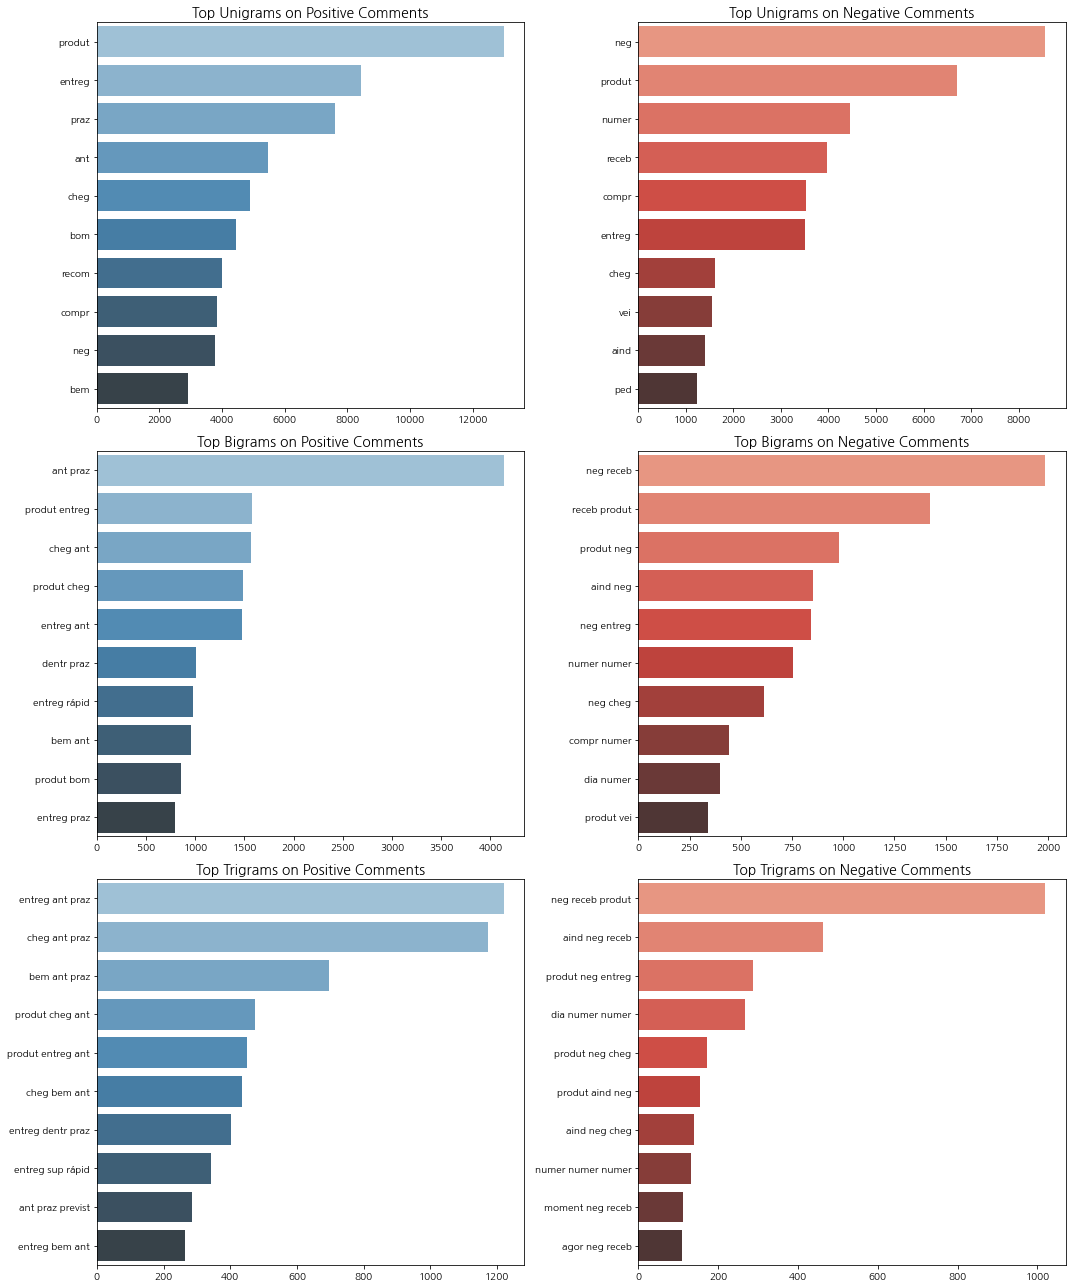

In [38]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    # format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

In [39]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [40]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

In [41]:
# Defining X and y 
idx_reviews = olist_order_reviews['review_comment_message'].dropna().index
score = olist_order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


In [42]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [43]:
class BinaryClassifiersAnalysis:
    """
    This class makes the work on training binary classifiers easier by bringing useful functions for training,
    purposing search on hyperparameters space, evaluating metrics and much more
    """

    def __init__(self):
        self.classifiers_info = {}

    def fit(self, classifiers, X, y, approach='', random_search=False, scoring='roc_auc', cv=5, verbose=5, n_jobs=-1):
        """
        This function receives information from classifiers to be trained, the data to be used on training and other
        parameters for fitting the model to the data.

        Parameters
        ----------
        :param classifiers: dictionary containing estimators and hyperparameters inner dict [type: dict]
        :param X: object containing features already prepared for training the model [type: np.array]
        :param y: object containing the model target variable [type: np.array]
        :param approach: string to be added on model's name as sufix for identifying purposes [type: string, default: '']
        :param random_search: guides the application of Randomized Search on training [type: bool, default: True]
        :param scoring: scoring metric to be optimized on random search [type: string, default: 'roc_auc']
        :param cv: K-folds used on random search cross-validation [type: int, default: 5]
        :param verbose: verbose param from RandomizedSearchCV [type: int, default: 5]
        :param n_jobs: n_jobs param from RandomizedSarchCV [type: int, default: -1]

        Return
        ------
        This method don't return anything but it fills some class attributes like self.classifiers_info dict

        Application
        -----------
        # Creating dictionary object for storing models information
        set_classifiers = {
            'ModelName': {
                'model': ClassifierEstimator(),
                'params': clf_dict_params
            }
        }
        trainer = BinaryClassifierAnalysis()
        trainer.fit(set_classifiers, X_train_prep, y_train, random_search=True, cv=5)
        """

        # Iterating trough every model in the dictionary of classifiers
        for model_name, model_info in classifiers.items():
            clf_key = model_name + approach
            print(f'Training model {clf_key}\n')

            # Creating an empty dict for storing model information
            self.classifiers_info[clf_key] = {}

            # Application of RandomizedSearchCV
            if random_search:
                rnd_search = RandomizedSearchCV(model_info['model'], model_info['params'], scoring=scoring, cv=cv,
                                                verbose=verbose, random_state=42, n_jobs=n_jobs)
                rnd_search.fit(X, y)

                # Saving the best estimator into the model's dict
                self.classifiers_info[clf_key]['estimator'] = rnd_search.best_estimator_
            else:
                self.classifiers_info[clf_key]['estimator'] = model_info['model'].fit(X, y)

    def compute_train_performance(self, model_name, estimator, X, y, cv=5):
        """
        This function applies cross validation to retrieve useful metrics for the classification model.
        In practice, this function would be called by another one (usually with compute_test_performance as well)

        Parameters
        ----------
        :param model_name: key-string that identifies a model at self.classifiers_info dict [type: string]
        :param estimator:
        :param X: object containing features already prepared for training the model [type: np.array]
        :param y: object containing the model target variable [type: np.array]
        :param cv: k-folds for cross validation application on training evaluation

        Return
        ------
        :return train_performance: DataFrame containing model metrics calculated using cross validation

        Application
        -----------
        # Evaluating training performance using cross-validation
        df_performances = trainer.compute_train_performance('DecisionTrees', trained_model, X_train, y_train, cv=5)
        """

        # Computing metrics using cross validation
        t0 = time.time()
        accuracy = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy').mean()
        precision = cross_val_score(estimator, X, y, cv=cv, scoring='precision').mean()
        recall = cross_val_score(estimator, X, y, cv=cv, scoring='recall').mean()
        f1 = cross_val_score(estimator, X, y, cv=cv, scoring='f1').mean()

        # Probas for calculating AUC
        try:
            y_scores = cross_val_predict(estimator, X, y, cv=cv, method='decision_function')
        except:
            # Tree based models don't have 'decision_function()' method, but 'predict_proba()'
            y_probas = cross_val_predict(estimator, X, y, cv=cv, method='predict_proba')
            y_scores = y_probas[:, 1]
        auc = roc_auc_score(y, y_scores)

        # Saving scores on self.classifiers_info dictionary
        self.classifiers_info[model_name]['train_scores'] = y_scores

        # Creating a DataFrame with metrics
        t1 = time.time()
        delta_time = t1 - t0
        train_performance = {}
        train_performance['model'] = model_name
        train_performance['approach'] = f'Treino {cv} K-folds'
        train_performance['acc'] = round(accuracy, 4)
        train_performance['precision'] = round(precision, 4)
        train_performance['recall'] = round(recall, 4)
        train_performance['f1'] = round(f1, 4)
        train_performance['auc'] = round(auc, 4)
        train_performance['total_time'] = round(delta_time, 3)

        return pd.DataFrame(train_performance, index=train_performance.keys()).reset_index(drop=True).loc[:0, :]

    def compute_test_performance(self, model_name, estimator, X, y):
        """
        This function retrieves metrics from the trained model on test data.
        In practice, this function would be called by another one (usually with compute_train_performance as well)

        Parameters
        ----------
        :param model_name: key-string that identifies a model at self.classifiers_info dict [type: string]
        :param estimator:
        :param X: object containing features already prepared for training the model [type: np.array]
        :param y: object containing the model target variable [type: np.array]

        Return
        ------
        :return test_performance: DataFrame containing model metrics calculated on test data

        Application
        -----------
        # Evaluating test data performance
        df_performances = trainer.compute_test_performance('DecisionTrees', trained_model, X_train, y_train)
        """

        # Predicting data using the trained model and computing probabilities
        t0 = time.time()
        y_pred = estimator.predict(X)
        y_proba = estimator.predict_proba(X)
        y_scores = y_proba[:, 1]

        # Retrieving metrics using test data
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_scores)

        # Saving probabilities on treined classifiers dictionary
        self.classifiers_info[model_name]['test_scores'] = y_scores

        # Creating a DataFrame with metrics
        t1 = time.time()
        delta_time = t1 - t0
        test_performance = {}
        test_performance['model'] = model_name
        test_performance['approach'] = f'Teste'
        test_performance['acc'] = round(accuracy, 4)
        test_performance['precision'] = round(precision, 4)
        test_performance['recall'] = round(recall, 4)
        test_performance['f1'] = round(f1, 4)
        test_performance['auc'] = round(auc, 4)
        test_performance['total_time'] = round(delta_time, 3)

        return pd.DataFrame(test_performance, index=test_performance.keys()).reset_index(drop=True).loc[:0, :]

    def evaluate_performance(self, X_train, y_train, X_test, y_test, cv=5, save=False, overwrite=True,
                             performances_filepath='model_performances.csv'):
        """
        This function centralizes the evaluating metric process by calling train and test evaluation functions.

        Parameters
        ----------
        :param X_train: training data to be used on evaluation [np.array]
        :param y_train: training target variable to be used on evaluation [type: np.array]
        :param X_test: testing data to be used on evaluation [np.array]
        :param y_test: testing target variable to be used on evaluation [type: np.array]
        :param cv: K-folds used on cross validation step [type: int, default: 5]
        :param save: flag that guides saving the final DataFrame with metrics [type: bool, default: False]
        :param overwrite: flag that guides the overwriting of a saved metrics file [type: bool, default: True]
        :param performances_filepath: path reference for saving model performances dataset [type: string,
                                                                        default: 'model_performances.csv']

        Return
        ------
        :return df_performance: DataFrame containing model metrics calculated on training and test data

        Application
        -----------
        # Evaluating performance on training and testint
        df_performance = trainer.evaluate_performance(X_train, y_train, X_test, y_test, save=True)
        """

        # Iterating over each trained classifier at classifiers_info dictionary
        df_performances = pd.DataFrame({})
        for model_name, model_info in self.classifiers_info.items():

            # Validating if the model was already trained (the key 'train_performance' will be at model_info dict if so)
            if 'train_performance' in model_info.keys():
                df_performances = df_performances.append(model_info['train_performance'])
                df_performances = df_performances.append(model_info['test_performance'])
                continue

            # Returning the estimator for calling the evaluation functions
            print(f'Evaluating model {model_name}\n')
            estimator = model_info['estimator']

            # Retrieving training and testing metrics by calling inner functions
            train_performance = self.compute_train_performance(model_name, estimator, X_train, y_train, cv=cv)
            test_performance = self.compute_test_performance(model_name, estimator, X_test, y_test)

            # Putting results on model's dictionary (classifiers_info)
            self.classifiers_info[model_name]['train_performance'] = train_performance
            self.classifiers_info[model_name]['test_performance'] = test_performance

            # Building and unique DataFrame with performances retrieved
            model_performance = train_performance.append(test_performance)
            df_performances = df_performances.append(model_performance)

            # Saving some attributes on model_info dictionary for further access
            model_data = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test
            }
            model_info['model_data'] = model_data

        # Saving the metrics file if applicable
        if save:
            # Adding information of measuring and execution time
            cols_performance = list(df_performances.columns)
            df_performances['anomesdia'] = datetime.now().strftime('%Y%m%d')
            df_performances['anomesdia_datetime'] = datetime.now()
            df_performances = df_performances.loc[:, ['anomesdia', 'anomesdia_datetime'] + cols_performance]

            # Validating overwriting or append on data already saved
            if overwrite:
                df_performances.to_csv(performances_filepath, index=False)
            else:
                try:
                    # If overwrite is False, tries reading existing metrics data and applying append on it
                    log_performances = pd.read_csv(performances_filepath)
                    full_performances = log_performances.append(df_performances)
                    full_performances.to_csv(performances_filepath, index=False)
                except FileNotFoundError:
                    print('Log de performances do modelo não existente no caminho especificado. Salvando apenas o atual.')
                    df_performances.to_csv(performances_filepath, index=False)

        return df_performances

    def feature_importance_analysis(self, features, specific_model=None, graph=True, ax=None, top_n=30,
                                    palette='viridis', save=False, features_filepath='features_info.csv'):
        """
        This function retrieves the feature importance from a given model. It can also build a bar chart
        for top_n most important features and plot it on the notebook.

        Paramters
        ---------
        :param features: list of model features used on training [type: list]
        :param specific_model: information that guides the returning of feature importance for a specific model*
        :param graph: flag that guides bar chart plotting at the end of execution [type: bool, default: True]
        :param ax: axis for plotting the bar chart [type: matplotlib.axes, default: None]
        :param top_n: parameter for showing up just top most important features [type: int, default: 30]
        :param palette: color configuration for feature importance bar chart [type: string, default: 'viridis']
        :param save: flag for saving the dataset returned [type: bool, default: False]
        :param features_filepath: path for saving the feature iportance dataset [type: string, default: 'features_info.csv']

        Returns
        -------
        :return: model_feature_importance: pandas DataFrame with feature importances extracted by trained models
        """

        # Iterating over each trained classifiers on classifiers_info dictionary
        feat_imp = pd.DataFrame({})
        all_feat_imp = pd.DataFrame({})
        for model_name, model_info in self.classifiers_info.items():
            # Creating a pandas DataFrame with model feature importance
            try:
                importances = model_info['estimator'].feature_importances_
            except:
                # If the given model doesn't have the feature_importances_ method, just continue for the next
                continue
            # Preparing the dataset with useful information
            feat_imp['feature'] = features
            feat_imp['importance'] = importances
            feat_imp['anomesdia'] = datetime.now().strftime('%Y%m')
            feat_imp['anomesdia_datetime'] = datetime.now()
            feat_imp.sort_values(by='importance', ascending=False, inplace=True)
            feat_imp.reset_index(drop=True, inplace=True)

            # Saving the feature iportance at model's dictionary (classifiers_info)
            self.classifiers_info[model_name]['feature_importances'] = feat_imp
            all_feat_imp = all_feat_imp.append(feat_imp)
            all_feat_imp['model'] = model_name

        # Retrieving feature importance for a specific model
        if specific_model is not None:
            try:
                model_feature_importance = self.classifiers_info[specific_model]['feature_importances']
                if graph:
                    # Plotting the bar chart
                    sns.barplot(x='importance', y='feature', data=model_feature_importance.iloc[:top_n, :],
                                ax=ax, palette=palette)
                    format_spines(ax, right_border=False)
                    ax.set_title(f'Top {top_n} {specific_model} Features mais Relevantes', size=14, color='dimgrey')

                # Saving features for a specific model
                if save:
                    model_feature_importance['model'] = specific_model
                    order_cols = ['anomesdia', 'anomesdia_datetime', 'model', 'feature', 'importance']
                    model_feature_importance = model_feature_importance.loc[:, order_cols]
                    model_feature_importance.to_csv(features_filepath, index=False)
                return model_feature_importance

            except:
                # Exception raised if the "specific_model" param doesn't match with any model's dictionary key
                print(f'Classificador {specific_model} não existente nas chaves de classificadores treinados.')
                print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
                return None

        else:
            # Validating feature importance saving if not passing specific_model param
            if save:
                order_cols = ['anomesdia', 'anomedia_datetime', 'model', 'feature', 'importance']
                all_feat_imp = all_feat_imp.loc[:, order_cols]
                all_feat_imp.to_csv(features_filepath, index=False)
            return all_feat_imp

        # Non-matching param combination (it can't be possible plotting bar chart for all models)
        if graph and specific_model is None:
            print('Por favor, escolha um modelo específico para visualizar o gráfico das feature importances')
            return None

    def plot_roc_curve(self, figsize=(16, 6)):
        """
        This function iterates over each estimator in classifiers_info dictionary and plots the ROC Curve for
        each one for training (first axis) and testing data (second axis)

        Paramaters
        ----------
        :param figsize: figure size for the plot [type: tuple, default: (16, 6)]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for ROC Curve

        Application
        -----------
        trainer.plot_roc_curve()
        """

        # Creating matplotlib figure and axis for ROC Curve plot
        fig, axs = plt.subplots(ncols=2, figsize=figsize)

        # Iterating over trained models
        for model_name, model_info in self.classifiers_info.items():
            # Returning y data for the model (training and testing)
            y_train = model_info['model_data']['y_train']
            y_test = model_info['model_data']['y_test']

            # Returning scores already calculated after performance evaluation
            train_scores = model_info['train_scores']
            test_scores = model_info['test_scores']

            # Calculating false positives and true positives rate
            train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_scores)
            test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_scores)

            # Returning the auc metric for training and testing already calculated after model evaluation
            train_auc = model_info['train_performance']['auc'].values[0]
            test_auc = model_info['test_performance']['auc'].values[0]

            # Plotting graph (training data)
            plt.subplot(1, 2, 1)
            plt.plot(train_fpr, train_tpr, linewidth=2, label=f'{model_name} auc={train_auc}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.axis([-0.02, 1.02, -0.02, 1.02])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - Train Data')
            plt.legend()

            # Plotting graph (testing data)
            plt.subplot(1, 2, 2)
            plt.plot(test_fpr, test_tpr, linewidth=2, label=f'{model_name} auc={test_auc}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.axis([-0.02, 1.02, -0.02, 1.02])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - Test Data', size=12)
            plt.legend()

        plt.show()

    def custom_confusion_matrix(self, model_name, y_true, y_pred, classes, cmap, normalize=False):
        """
        This function is used for plotting and customizing a confusion matrix for a specific model. In practice,
        this function can be called by a top level one for plotting matrix for many models.

        Parameters
        ----------
        :param model_name: key reference for extracting model's estimator from classifiers_dict [type: string]
        :param y_true: label reference for the target variable [type: np.array]
        :param y_pred: array of predictions given by the respective model [type: np.array]
        :param classes: alias for classes [type: string]
        :param cmap: this parameters guides the colorway for the matrix [type: matplotlib.colormap]
        :param normalize: normalizes the entries for the matrix [type: bool, default: False]

        Returns
        -------
        :return: This functions doesn't return any object besides of plotting the confusion matrix

        Application
        -----------
        Please refer to the self.plot_confusion_matrix() function

        """

        # Returning a confusion matrix given the labels and predictions passed as args
        conf_mx = confusion_matrix(y_true, y_pred)

        # Plotando matriz
        plt.imshow(conf_mx, interpolation='nearest', cmap=cmap)
        plt.colorbar()
        tick_marks = np.arange(len(classes))

        # Customizando eixos
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        # Customizando entradas
        fmt = '.2f' if normalize else 'd'
        thresh = conf_mx.max() / 2.
        for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
            plt.text(j, i, format(conf_mx[i, j]),
                     horizontalalignment='center',
                     color='white' if conf_mx[i, j] > thresh else 'black')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'{model_name}\nConfusion Matrix', size=12)

    def plot_confusion_matrix(self, classes, normalize=False, cmap=plt.cm.Blues):
        """
        This function plots a confusion matrix for training and testing data for each classifier at
        self.classifiers_dict dictionary

        Parameters
        ----------
        :param classes: labels for the target variable [type: string]
        :param normalize: flag that guides the normalization of matrix values [type: bool, default: False]
        :param cmap: param that colorizes the matrix [type: plt.cm, default: plt.cm.Blues]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for confusion matrix
        """

        # Defining parameters for ploting
        k = 1
        nrows = len(self.classifiers_info.keys())
        fig = plt.figure(figsize=(10, nrows * 4))
        sns.set(style='white', palette='muted', color_codes=True)

        # Iterating over each classifier
        for model_name, model_info in self.classifiers_info.items():
            # Returning data from each model
            X_train = model_info['model_data']['X_train']
            y_train = model_info['model_data']['y_train']
            X_test = model_info['model_data']['X_test']
            y_test = model_info['model_data']['y_test']

            # Making predictions for training (cross validation) and testing for returning confusion matrix
            train_pred = cross_val_predict(model_info['estimator'], X_train, y_train, cv=5)
            test_pred = model_info['estimator'].predict(X_test)

            # Plotting matrix (training data)
            plt.subplot(nrows, 2, k)
            self.custom_confusion_matrix(model_name + ' Train', y_train, train_pred, classes=classes, cmap=cmap,
                                         normalize=normalize)
            k += 1

            # Plotting matrix (testing data)
            plt.subplot(nrows, 2, k)
            self.custom_confusion_matrix(model_name + ' Test', y_test, test_pred, classes=classes, cmap=plt.cm.Greens,
                                         normalize=normalize)
            k += 1

        plt.tight_layout()
        plt.show()

    def plot_learning_curve(self, model_name, ax, ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
        """
        This function calculates and plots the learning curve for a trained model

        Parameters
        ----------
        :param model_name: Key reference for extracting an estimator from classifiers_dict dictionary [type: string]
        :param ax: axis reference for plotting the learning curve [type: matplotlib.axis]
        :param ylim: configuration of the limit on plot vertical axis [type: int, default: None]
        :param cv: k-folds used on cross validation [type: int, default: 5]
        :param n_jobs: number of cores used on retrieving the learning curve params [type: int, default: 1]
        :param train_sizes: array that guides the steps bins used on learning curve [type: np.array,
                                                                                    default:np.linspace(.1, 1.0, 10)]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for the learning curve

        Application
        -----------
        # Plotting the learning curve for a specific model
        fig, ax = plt.subplots(figsize=(16, 6))
        trainer.plot_learning_curve(model_name='LightGBM', ax=ax)
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Returning useful data for the model
        X_train = model['model_data']['X_train']
        y_train = model['model_data']['y_train']

        # Calling the learning curve model for retrieving the scores for training and validation
        train_sizes, train_scores, val_scores = learning_curve(model['estimator'], X_train, y_train, cv=cv,
                                                               n_jobs=n_jobs, train_sizes=train_sizes)

        # Computing averages and standard deviation (training and validation)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)

        # Results on training data
        ax.plot(train_sizes, train_scores_mean, 'o-', color='navy', label='Training Score')
        ax.fill_between(train_sizes, (train_scores_mean - train_scores_std), (train_scores_mean + train_scores_std),
                        alpha=0.1, color='blue')

        # Results on cross validation
        ax.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Cross Val Score')
        ax.fill_between(train_sizes, (val_scores_mean - val_scores_std), (val_scores_mean + val_scores_std),
                        alpha=0.1, color='crimson')

        # Customizing graph
        ax.set_title(f'Model {model_name} - Learning Curve', size=14)
        ax.set_xlabel('Training size (m)')
        ax.set_ylabel('Score')
        ax.grid(True)
        ax.legend(loc='best')

    def plot_score_distribution(self, model_name, shade=False):
        """
        This function plots a kdeplot for training and testing data splitting by target class

        Parameters
        ----------
        :param model_name: key reference for the trained model [type: string]
        :param shade: shade param for seaborn's kdeplot [type: bool, default: False]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for the score distribution

        Application
        -----------
        # Ploting scores distribution for a model
        plot_score_distribution(model_name='LightGBM', shade=True)
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Retrieving y array for training and testing data
        y_train = model['model_data']['y_train']
        y_test = model['model_data']['y_test']

        # Retrieving training and testing scores
        train_scores = model['train_scores']
        test_scores = model['test_scores']

        # Plotting scores distribution
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
        sns.kdeplot(train_scores[y_train == 1], ax=axs[0], label='y=1', shade=shade, color='darkslateblue')
        sns.kdeplot(train_scores[y_train == 0], ax=axs[0], label='y=0', shade=shade, color='crimson')
        sns.kdeplot(test_scores[y_test == 1], ax=axs[1], label='y=1', shade=shade, color='darkslateblue')
        sns.kdeplot(test_scores[y_test == 0], ax=axs[1], label='y=0', shade=shade, color='crimson')

        # Customizing plots
        format_spines(axs[0], right_border=False)
        format_spines(axs[1], right_border=False)
        axs[0].set_title('Score Distribution - Training Data', size=12, color='dimgrey')
        axs[1].set_title('Score Distribution - Testing Data', size=12, color='dimgrey')
        plt.suptitle(f'Score Distribution: a Probability Approach for {model_name}\n', size=14, color='black')
        plt.show()

    def plot_score_bins(self, model_name, bin_range):
        """
        This function plots a score distribution based on quantity of each class in a specific bin_range set

        Parameters
        ----------
        :param model_name: key reference for the trained model [type: string]
        :param bin_range: defines a range of splitting the bins array [type: float]

        Returns
        -------
        This function doesn't return anything but the matplotlib plot for the score bins distribution

        Application
        -----------
        # Ploting scores distribution for a model in another approach
        plot_score_bins(model_name='LightGBM', bin_range=0.1)
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Creating the bins array
        bins = np.arange(0, 1.01, bin_range)
        bins_labels = [str(round(list(bins)[i - 1], 2)) + ' a ' + str(round(list(bins)[i], 2)) for i in range(len(bins))
                       if i > 0]

        # Retrieving the train scores and creating a DataFrame
        train_scores = model['train_scores']
        y_train = model['model_data']['y_train']
        df_train_scores = pd.DataFrame({})
        df_train_scores['scores'] = train_scores
        df_train_scores['target'] = y_train
        df_train_scores['faixa'] = pd.cut(train_scores, bins, labels=bins_labels)

        # Computing the distribution for each bin
        df_train_rate = pd.crosstab(df_train_scores['faixa'], df_train_scores['target'])
        df_train_percent = df_train_rate.div(df_train_rate.sum(1).astype(float), axis=0)

        # Retrieving the test scores and creating a DataFrame
        test_scores = model['test_scores']
        y_test = model['y_test']
        df_test_scores = pd.DataFrame({})
        df_test_scores['scores'] = test_scores
        df_test_scores['target'] = y_test
        df_test_scores['faixa'] = pd.cut(test_scores, bins, labels=bins_labels)

        # Computing the distribution for each bin
        df_test_rate = pd.crosstab(df_test_scores['faixa'], df_test_scores['target'])
        df_test_percent = df_test_rate.div(df_test_rate.sum(1).astype(float), axis=0)

        # Defining figure for plotting
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

        # Plotting the bar chart for each bin
        for df_scores, ax in zip([df_train_scores, df_test_scores], [axs[0, 0], axs[0, 1]]):
            sns.countplot(x='faixa', data=df_scores, hue='target', ax=ax, palette=['darkslateblue', 'crimson'])
            AnnotateBars(n_dec=0, color='dimgrey').vertical(ax)
            ax.legend(loc='upper right')
            format_spines(ax, right_border=False)

        # Plotting percentage for each class in each bin
        for df_percent, ax in zip([df_train_percent, df_test_percent], [axs[1, 0], axs[1, 1]]):
            df_percent.plot(kind='bar', ax=ax, stacked=True, color=['darkslateblue', 'crimson'], width=0.6)

            # Customizing plots
            for p in ax.patches:
                # Collecting params for labeling
                height = p.get_height()
                width = p.get_width()
                x = p.get_x()
                y = p.get_y()

                # Formatting params and putting into the graph
                label_text = f'{round(100 * height, 1)}%'
                label_x = x + width - 0.30
                label_y = y + height / 2
                ax.text(label_x, label_y, label_text, ha='center', va='center', color='white',
                        fontweight='bold', size=10)
            format_spines(ax, right_border=False)

        # Final definitions
        axs[0, 0].set_title('Quantity of each Class by Range - Train', size=12, color='dimgrey')
        axs[0, 1].set_title('Quantity of each Class by Range - Test', size=12, color='dimgrey')
        axs[1, 0].set_title('Percentage of each Class by Range - Train', size=12, color='dimgrey')
        axs[1, 1].set_title('Percentage of each Class by Range - Test', size=12, color='dimgrey')
        plt.suptitle(f'Score Distribution by Range - {model_name}\n', size=14, color='black')
        plt.tight_layout()
        plt.show()

    def shap_analysis(self, model_name, features):
        """
        This function brings a shap analysis for each feature into the model

        Parameters
        ----------
        :param model_name: key reference for the trained model [type: string]
        :param features: features list for the model [type: list]

        Returns
        -------
        This function doesn't return anything but the shap plot analysis

        Application
        -----------
        # Executing a shap analysis
        trainer.shap_analysis(model_name='LightGBM')
        """

        # Returning the model to be evaluated
        try:
            model = self.classifiers_info[model_name]
        except:
            print(f'Classificador {model_name} não foi treinado.')
            print(f'Opções possíveis: {list(self.classifiers_info.keys())}')
            return None

        # Retrieving training data
        X_train = model['X_train']

        # Applying shap approach
        explainer = shap.TreeExplainer(model)
        df_train = pd.DataFrame(X_train, columns=features)
        shap_values = explainer.shap_values(df_train)

        # Plotting a summary plot using shap
        shap.summary_plot(shap_values[1], df_train)


def cross_val_performance(estimator, X, y, cv=5):
    """
    This function applies cross validation to retrieve useful metrics for the classification model.
    In practice, this function would be called by another one (usually with compute_test_performance as well)

    Parameters
    ----------
    :param estimator: a trained model to be used on evaluation [type: model]
    :param X: object containing features already prepared for training the model [type: np.array]
    :param y: object containing the model target variable [type: np.array]
    :param cv: k-folds for cross validation application on training evaluation

    Return
    ------
    :return train_performance: DataFrame containing model metrics calculated using cross validation

    Application
    -----------
    # Evaluating training performance using cross-validation
    df_performances = trainer.compute_train_performance('DecisionTrees', trained_model, X_train, y_train, cv=5)
    """

    # Computing metrics using cross validation
    t0 = time.time()
    accuracy = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(estimator, X, y, cv=cv, scoring='precision').mean()
    recall = cross_val_score(estimator, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(estimator, X, y, cv=cv, scoring='f1').mean()

    # Probas for calculating AUC
    try:
        y_scores = cross_val_predict(estimator, X, y, cv=cv, method='decision_function')
    except:
        # Tree based models don't have 'decision_function()' method, but 'predict_proba()'
        y_probas = cross_val_predict(estimator, X, y, cv=cv, method='predict_proba')
        y_scores = y_probas[:, 1]
    auc = roc_auc_score(y, y_scores)

    # Creating a DataFrame with metrics
    t1 = time.time()
    delta_time = t1 - t0
    train_performance = {}
    train_performance['model'] = estimator.__class__.__name__
    train_performance['approach'] = 'Final Model'
    train_performance['acc'] = round(accuracy, 4)
    train_performance['precision'] = round(precision, 4)
    train_performance['recall'] = round(recall, 4)
    train_performance['f1'] = round(f1, 4)
    train_performance['auc'] = round(auc, 4)
    train_performance['total_time'] = round(delta_time, 3)
    df_performance = pd.DataFrame(train_performance, index=train_performance.keys()).reset_index(drop=True).loc[:0, :]

    # Adding information of measuring and execution time
    cols_performance = list(df_performance.columns)
    df_performance['anomesdia'] = datetime.now().strftime('%Y%m%d')
    df_performance['anomesdia_datetime'] = datetime.now()
    df_performance = df_performance.loc[:, ['anomesdia', 'anomesdia_datetime'] + cols_performance]

    return df_performance
    

"""
-----------------------------------
---------- 2. CLUSTERING ----------
-----------------------------------
"""


def elbow_method_kmeans(df, K_min, K_max, figsize=(16, 6)):
    """
    This function applies the elbow method using K-means clustering algorithm in order to select the best number of
    k clusters for the task

    Parameters
    ----------
    :param df: DataFrame with data to be clustered [type: pd.DataFrame]
    :param K_min: minimum index of K to be evaluated on elbow method [type: int]
    :param K_max: maximum index of K to be evaluated on elbow method [type: int]
    :param figsize: figure dimension for the matplotlib plot [type: tuple, default: (16, 5)]

    Returns
    -------
    :return: This function doesn't return anything but the elbow method plot for further analysis

    Application
    -----------
    # Looking at the elbow graphic for selection the best k number of clusters
    elbow_method_kmeans(df=data, K_min=1, K_max=8)
    """

    # Training differente K-Means models for each number of flusters in range K_min, K_max
    square_dist = []
    for k in range(K_min, K_max+1):
        km = KMeans(n_clusters=k)
        km.fit(df)
        # Computing and keeping the square distances for each model configuration
        square_dist.append(km.inertia_)

    # Plotting elbow analysis
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(K_min, K_max), y=square_dist, color='cornflowerblue', marker='o')

    # Customizing the graph
    # format_spines(ax, right_border=False)
    ax.set_title('Elbow Method - KMeans Model', size=14, color='dimgrey')
    ax.set_xlabel('Total of Clusters (K)')
    ax.set_ylabel('Euclidian Distance')
    plt.show()


def plot_kmeans_clusters_2d(df, k_means, figsize=(16, 6), cmap='viridis'):
    """
    This function plots and customizes a 2D result from a trained K-means algorithm

    Parameters
    ----------
    :param df: DataFrame with the two columns used on training the K-means algorithm [type: pd.DataFrame]
    :param kmeans: trained K-means model [type: model]
    :param figsize: figure dimension for the plot [type: tuple, default: (16, 6)]
    :param cmap: param for coloring the plot with a specific palette [type: string, default: 'viridis]

    Returns
    -------
    :return: This function doesn't return anything but the K-means algorithm plot

    Application
    -----------
    # Visualizing the kmeans result on a trained 2D model data
    model = KMeans(n_clusters=3)
    cluster_data = df.loc[:, two_columns_list]
    k_means.fit(cluster_data)
    plot_kmeans_clusters_2d(cluster_data, model)
    """

    # Computing y_kmeans and centers
    y_kmeans = k_means.predict(df)
    centers = k_means.cluster_centers_

    # REtrieving values and defining layout
    variaveis = df.columns
    X = df.values
    sns.set(style='white', palette='muted', color_codes=True)

    # Plotting the scatterplot chart
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap=cmap)
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

    # Customizing the graph
    ax.set_title(f'K_Means aplicado entre {variaveis[0].upper()} e {variaveis[1].upper()}', size=14, color='dimgrey')
    # format_spines(ax, right_border=False)
    ax.set_xlabel(variaveis[0])
    ax.set_ylabel(variaveis[1])
    plt.show()

In [44]:
# from ml_utils import BinaryClassifiersAnalysis, cross_val_performance
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix

In [45]:
df_comments

score                                            comment  \
0          5              Recebi bem antes do prazo estipulado.   
1          5  Parabéns lojas lannister adorei comprar pela I...   
2          4  aparelho eficiente. no site a marca do aparelh...   
3          4    Mas um pouco ,travando...pelo valor ta Boa.\r\n   
4          5  Vendedor confiável, produto ok e entrega antes...   
...      ...                                                ...   
40972      4  para este produto recebi de acordo com a compr...   
40973      5  Entregou dentro do prazo. O produto chegou em ...   
40974      3  O produto não foi enviado com NF, não existe v...   
40975      5  Excelente mochila, entrega super rápida. Super...   
40976      1  meu produto chegou e ja tenho que devolver, po...   

                                            re_breakline  \
0                  Recebi bem antes do prazo estipulado.   
1      Parabéns lojas lannister adorei comprar pela I...   
2      aparelho eficiente. no site a marca do aparelh...   
3          Mas um pouco ,travando...pelo valor ta Boa.     
4      Vendedor confiável, produto ok e entrega antes...   
...                                                  ...   
40972  para este produto recebi de acordo com a compr...   
40973  Entregou dentro do prazo. O produto chegou em ...   
40974  O produto não foi enviado com NF, não existe v...   
40975  Excelente mochila, entrega super rápida. Super...   
40976  meu produto chegou e ja tenho que devolver, po...   

                                           re_hiperlinks  \
0                  Recebi bem antes do prazo estipulado.   
1      Parabéns lojas lannister adorei comprar pela I...   
2      aparelho eficiente. no site a marca do aparelh...   
3          Mas um pouco ,travando...pelo valor ta Boa.     
4      Vendedor confiável, produto ok e entrega antes...   
...                                                  ...   
40972  para este produto recebi de acordo com a compr...   
40973  Entregou dentro do prazo. O produto chegou em ...   
40974  O produto não foi enviado com NF, não existe v...   
40975  Excelente mochila, entrega super rápida. Super...   
40976  meu produto chegou e ja tenho que devolver, po...   

                                                re_dates  \
0                  Recebi bem antes do prazo estipulado.   
1      Parabéns lojas lannister adorei comprar pela I...   
2      aparelho eficiente. no site a marca do aparelh...   
3          Mas um pouco ,travando...pelo valor ta Boa.     
4      Vendedor confiável, produto ok e entrega antes...   
...                                                  ...   
40972  para este produto recebi de acordo com a compr...   
40973  Entregou dentro do prazo. O produto chegou em ...   
40974  O produto não foi enviado com NF, não existe v...   
40975  Excelente mochila, entrega super rápida. Super...   
40976  meu produto chegou e ja tenho que devolver, po...   

                                                re_money  \
0                  Recebi bem antes do prazo estipulado.   
1      Parabéns lojas lannister adorei comprar pela I...   
2      aparelho eficiente. no site a marca do aparelh...   
3          Mas um pouco ,travando...pelo valor ta Boa.     
4      Vendedor confiável, produto ok e entrega antes...   
...                                                  ...   
40972  para este produto recebi de acordo com a compr...   
40973  Entregou dentro do prazo. O produto chegou em ...   
40974  O produto não foi enviado com NF, não existe v...   
40975  Excelente mochila, entrega super rápida. Super...   
40976  meu produto chegou e ja tenho que devolver, po...   

                                              re_numbers  \
0                  Recebi bem antes do prazo estipulado.   
1      Parabéns lojas lannister adorei comprar pela I...   
2      aparelho eficiente. no site a marca do aparelh...   
3          Mas um pouco ,travando...pelo valor ta Boa.     
4      Vendedor co

In [46]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

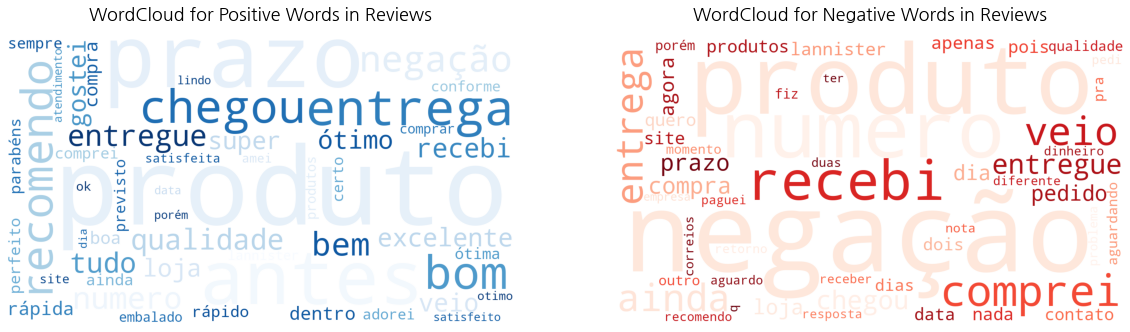

In [47]:
# Reading and preparing a mask for serving as wordcloud background
like_mask = np.array(Image.open(f"{root_path}like.png"))
bomb_mask = np.array(Image.open(f"{root_path}dislike.png"))
#angry_mask = angry_mask[:, :, -1]

# Transforming like mask
transf_like_mask = np.ndarray((like_mask.shape[0], like_mask.shape[1]), np.int32)
for i in range(len(like_mask)):
    transf_like_mask[i] = [0 if px == 0 else 255 for px in like_mask[i]]

# Transforming angry mask
transf_bomb_mask = np.ndarray((bomb_mask.shape[0], bomb_mask.shape[1]), np.int32)
for i in range(len(bomb_mask)):
    transf_bomb_mask[i] = [255 if px == 0 else 0 for px in bomb_mask[i]]
    
# Generating words
pos_comments = list(df_comments.query('sentiment_label == "positive"')['stopwords_removed'].values)
positive_words = ' '.join(pos_comments).split(' ')
neg_comments = list(df_comments.query('sentiment_label == "negative"')['stopwords_removed'].values)
negative_words = ' '.join(neg_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, #mask=transf_like_mask,
                      colormap='Blues', background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, #mask=transf_bomb_mask,
                      colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('WordCloud for Positive Words in Reviews', size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('WordCloud for Negative Words in Reviews', size=18, pad=20)

plt.show()

In [48]:
neg_comments[:3]

['gostaria saber sempre recebi compra agora decpcionou',
 'péssimo',
 'negação gostei comprei gato lebre']

## Review Positive / Negative : English

In [49]:
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

In [50]:
# Utilities
# from viz_utils import *
# from custom_transformers import *
# from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [51]:
# Importing libs
import os
import numpy as np
import pandas as pd
#from dev.training.project_transformers import ColumnMapping
# from custom_transformers import import_data, DropNullData, DropDuplicates
# from text_utils import re_breakline, re_dates, re_hiperlinks, re_money, re_negation, re_numbers, \
#     re_special_chars, re_whitespaces, ApplyRegex, StemmingProcess, StopWordsRemoval
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump
from sklearn.linear_model import LogisticRegression
# from ml_utils import BinaryClassifiersAnalysis, cross_val_performance
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

In [52]:
olist_order_reviews_translated = pd.read_csv(f'{root_path}olist_order_reviews_dataset_trans_en.csv')

In [53]:
olist_order_reviews_translated = olist_order_reviews_translated.dropna()
olist_order_reviews_translated.sample()

index                         review_id  \
35504  85839  bc304c258b5a10068d4e34a5fb355748   

                               order_id  review_score review_comment_title  \
35504  ddce482cc1785da2ee00c010675508d3             5         Lindo! Amei!   

        review_comment_message review_creation_date review_answer_timestamp  \
35504  Do jeito que eu queria.  2018-05-11 00:00:00     2018-05-12 00:21:20   

              trans_review_en  
35504  Just the way I wanted.

In [54]:
df_comments = olist_order_reviews_translated.loc[:, ['review_score', 'trans_review_en']]
df_comments.columns = ['review_score', 'review_comment_message']
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (9839, 2)


score                                            comment
0      4  efficient device. on the website the brand of ...
1      5  Reliable seller, ok product and delivery on time.
2      1                                           Terrible
3      5                                      store note 10
4      4  I received exactly what I expected. Other orde...

In [55]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]
    
    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """
    
    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1
        
    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """
    
    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

In [56]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [57]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Before: 
I was happy with. The fabric, but I think the top sheet was missing to be complete, I hope they launch it soon.

After: 
I was happy with. The fabric, but I think the top sheet was missing to be complete, I hope they launch it soon.



In [58]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [59]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
# print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

In [60]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [61]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
# print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26665, 41497, 41674])

In [62]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [63]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
# print_step_result(reviews_dates, reviews_money, idx_list=[26020, 33297, 32998])

In [64]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [65]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
The product is not in the correct measurements indicated in the offer. I will have to call you for exchange

After: 
The product is not in the correct measurements indicated in the offer. I will have to call you for exchange



In [66]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [67]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
# print_step_result(reviews_numbers, reviews_negation, idx_list=[4783, 4627, 4856, 4904])

In [68]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [69]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 135, 234])

--- Text 1 ---

Before: 
Everything is OK!

After: 
Everything is OK 

--- Text 2 ---

Before: 
Goods as ordered. It arrived before the deadline. I recommend!

After: 
Goods as ordered  It arrived before the deadline  I recommend 

--- Text 3 ---

Before: 
Product delivered on time.

After: 
Product delivered on time 



In [70]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [71]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

--- Text 1 ---

Before: 
store note  numero 

After: 
store note numero

--- Text 2 ---

Before: 
I received exactly what I expected  Other orders from other sellers were late  but this one arrived on time 

After: 
I received exactly what I expected Other orders from other sellers were late but this one arrived on time

--- Text 3 ---

Before: 
Very different photo  mainly the very thin synthetic grain    different from the photo

After: 
Very different photo mainly the very thin synthetic grain different from the photo



In [72]:
# Examples of some portuguese stopwords
import nltk
nltk.download('stopwords')
pt_stopwords = stopwords.words('english')
print(f'Total English stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total English stopwords in the nltk.corpous module: 179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [73]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('english')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [74]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Before: 
efficient device on the website the brand of the device is printed as numero disinfector and when it arrives it has another name update with the correct brand since it is the same device

After: 
efficient device website brand device printed numero disinfector arrives another name update correct brand since device

--- Text 2 ---

Before: 
Everything is OK

After: 
everything ok

--- Text 3 ---

Before: 
Great I m already using it

After: 
great already using



In [75]:
# Defining a function to remove the stopwords and to lower the comments
nltk.download('rslp')
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [76]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
efficient device website brand device printed numero disinfector arrives another name update correct brand since device

After: 
efficient devic websit brand devic printed numer disinfec arriv anoth nam updat correct brand sinc devic

--- Text 2 ---

Before: 
everything ok

After: 
everything ok

--- Text 3 ---

Before: 
different photo mainly thin synthetic grain different photo

After: 
different phot mainly thin synthetic grain different phot



In [77]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

In [78]:
# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (9839, 300)

Example of DataFrame of corpus features:


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


according  ad  addition  advertised  agreed  ahead  almost  already  als  \
0          0   0         0           0       0      0       0        0    0   
1          0   0         0           0       0      0       0        0    0   
2          0   0         0           0       0      0       0        0    0   
3          0   0         0           0       0      0       0        0    0   
4          0   0         0           0       0      0       0        0    0   

   alway  ...  without  wonderful  work  worked  working  worth  would  wrong  \
0      0  ...        0          0     0       0        0      0      0      0   
1      0  ...        0          0     0       0        0      0      0      0   
2      0  ...        0          0     0       0        0      0      0      0   
3      0  ...        0          0     0       0        0      0      0      0   
4      0  ...        0          0     0       0        0      0      0      0   

   ye  yet  
0   0    0  
1   0    0  
2   0    0  
3   0    0  
4   0    0  

[5 rows x 300 columns]

In [79]:
# Creating an object for the CountVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (9839, 300)

Example of DataFrame of corpus features:


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


according   ad  addition  advertised  agreed  ahead  almost  already  als  \
0        0.0  0.0       0.0         0.0     0.0    0.0     0.0      0.0  0.0   
1        0.0  0.0       0.0         0.0     0.0    0.0     0.0      0.0  0.0   
2        0.0  0.0       0.0         0.0     0.0    0.0     0.0      0.0  0.0   
3        0.0  0.0       0.0         0.0     0.0    0.0     0.0      0.0  0.0   
4        0.0  0.0       0.0         0.0     0.0    0.0     0.0      0.0  0.0   

   alway  ...  without  wonderful  work  worked  working  worth  would  wrong  \
0    0.0  ...      0.0        0.0   0.0     0.0      0.0    0.0    0.0    0.0   
1    0.0  ...      0.0        0.0   0.0     0.0      0.0    0.0    0.0    0.0   
2    0.0  ...      0.0        0.0   0.0     0.0      0.0    0.0    0.0    0.0   
3    0.0  ...      0.0        0.0   0.0     0.0      0.0    0.0    0.0    0.0   
4    0.0  ...      0.0        0.0   0.0     0.0      0.0    0.0    0.0    0.0   

    ye  yet  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 300 columns]

In [80]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# # Verifying results
# fig, ax = plt.subplots(figsize=(7, 7))
# donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
#            label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
#            ax=ax, colors=['darkslateblue', 'crimson'])

In [81]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('english')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [82]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

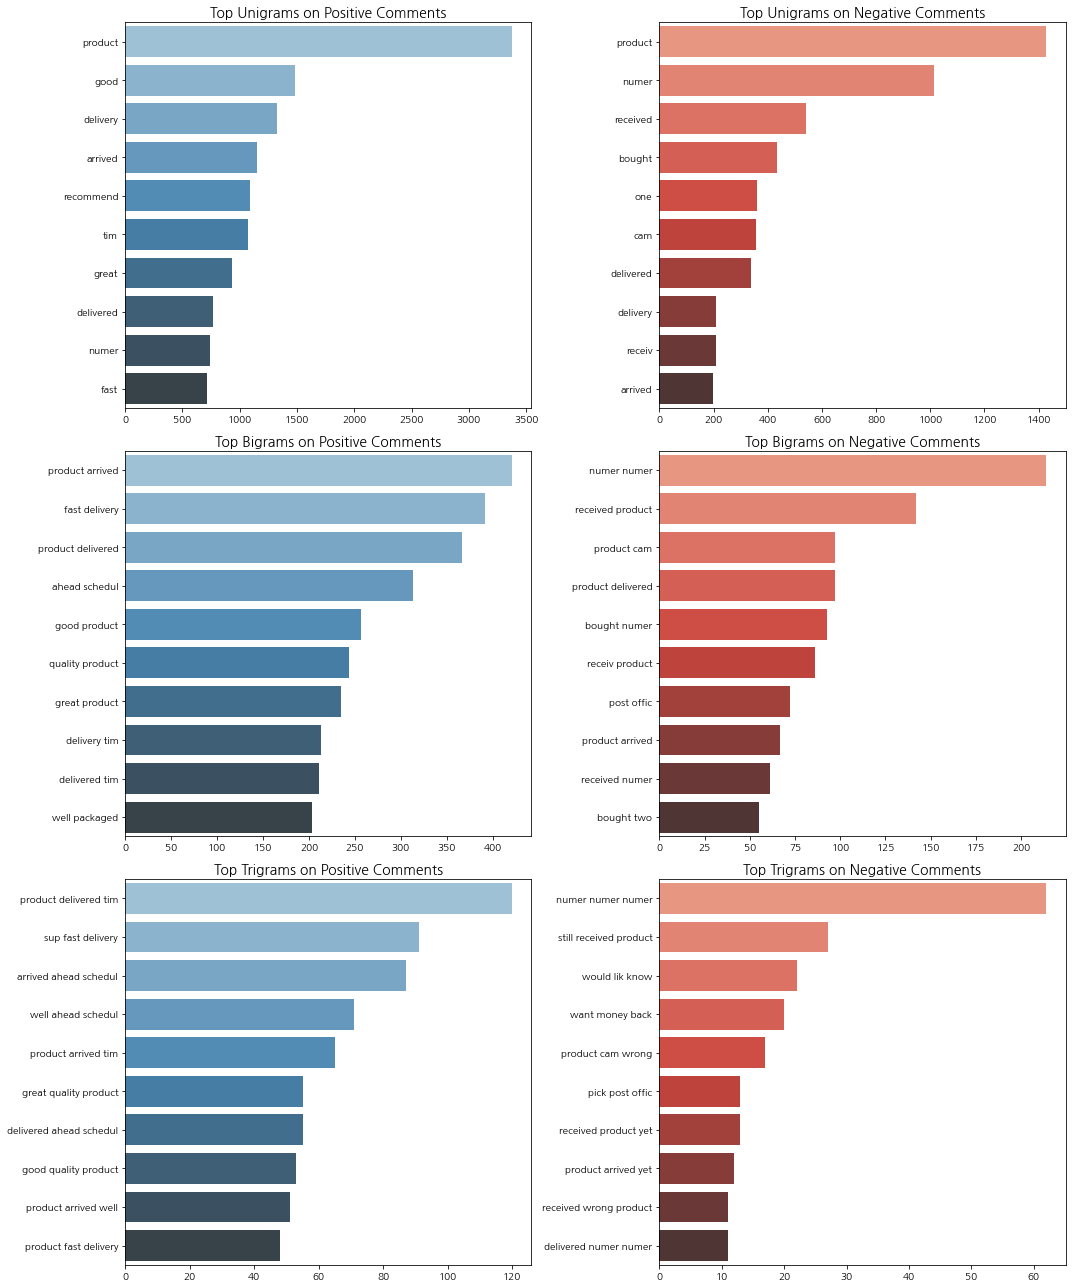

In [83]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    # format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

In [84]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [85]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('english'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

In [86]:
# Defining X and y 
idx_reviews = olist_order_reviews['review_comment_message'].dropna().index
score = olist_order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


In [87]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [88]:
# from ml_utils import BinaryClassifiersAnalysis, cross_val_performance
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix

In [89]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

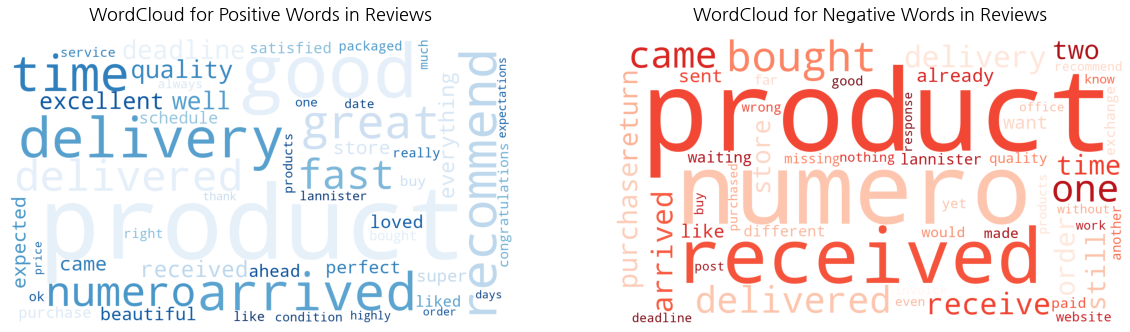

In [90]:
# Reading and preparing a mask for serving as wordcloud background
like_mask = np.array(Image.open(f"{root_path}like.png"))
bomb_mask = np.array(Image.open(f"{root_path}bomb.png"))
#angry_mask = angry_mask[:, :, -1]

# Transforming like mask
transf_like_mask = np.ndarray((like_mask.shape[0], like_mask.shape[1]), np.int32)
for i in range(len(like_mask)):
    transf_like_mask[i] = [0 if px == 0 else 255 for px in like_mask[i]]

# Transforming angry mask
transf_bomb_mask = np.ndarray((bomb_mask.shape[0], bomb_mask.shape[1]), np.int32)
for i in range(len(bomb_mask)):
    transf_bomb_mask[i] = [255 if px == 0 else 0 for px in bomb_mask[i]]
    
# Generating words
pos_comments = list(df_comments.query('sentiment_label == "positive"')['stopwords_removed'].values)
positive_words = ' '.join(pos_comments).split(' ')
neg_comments = list(df_comments.query('sentiment_label == "negative"')['stopwords_removed'].values)
negative_words = ' '.join(neg_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, #mask=transf_like_mask,
                      colormap='Blues', background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, #mask=transf_bomb_mask,
                      colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('WordCloud for Positive Words in Reviews', size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('WordCloud for Negative Words in Reviews', size=18, pad=20)

plt.show()

## Review Positive / Negative : Korean

In [91]:
olist_order_reviews_ko = pd.read_csv(f'{root_path}olist_order_reviews_dataset_trans_en_ko.csv')
olist_order_reviews_ko.head()

index                         review_id                          order_id  \
0      3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
1      4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   
2      9  8670d52e15e00043ae7de4c01cc2fe06  b9bf720beb4ab3728760088589c62129   
3     12  4b49719c8a200003f700d3d986ea1a19  9d6f15f95d01e79bd1349cc208361f09   
4     15  3948b09f7c818e2d86c9a546758b2335  e51478e7e277a83743b6f9991dbfa3fb   

   review_score review_comment_title  \
0             5                  NaN   
1             5                  NaN   
2             4            recomendo   
3             4                  NaN   
4             5      Super recomendo   

                              review_comment_message review_creation_date  \
0              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
1  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
2  aparelho eficiente. no site a marca do aparelh...  2018-05-22 00:00:00   
3    Mas um pouco ,travando...pelo valor ta Boa.\r\n  2018-02-16 00:00:00   
4  Vendedor confiável, produto ok e entrega antes...  2018-05-23 00:00:00   

  review_answer_timestamp                                    trans_review_en  \
0     2017-04-21 22:02:06     I received it well before the stipulated time.   
1     2018-03-02 10:26:53  Congratulations Lannister stores I loved shopp...   
2     2018-05-23 16:45:47  efficient device. on the website the brand of ...   
3     2018-02-20 10:52:22  But a little slowing down...for the price it's...   
4     2018-05-24 03:00:01  Reliable seller, ok product and delivery on time.   

                                     trans_review_ko  
0                                 정해진 시간 전에 잘 받았습니다.  
1  축하합니다 Lannister 매장 저는 안전하고 실용적인 온라인 쇼핑을 좋아했습니다...  
2  효율적인 장치. 웹사이트에 기기 브랜드가 3disinfector로 인쇄되어 있고 도...  
3                       다만 조금 느리긴 합니다만... 가격대비 좋습니다.  
4                        신뢰할 수있는 판매자, ok 제품 및 정시 배송.

In [92]:
olist_order_reviews_ko = olist_order_reviews_ko.dropna()
olist_order_reviews_ko.sample()

index                         review_id  \
28991  70258  9ef2072a9ce68b5ae7f4dbef927c0a4b   

                               order_id  review_score review_comment_title  \
28991  9e68e57b1d59b0b5e5f9c13701af153e             4            Recomendo   

                                  review_comment_message review_creation_date  \
28991  Recebimento rápido porém a embalagem chegou to...  2018-06-16 00:00:00   

      review_answer_timestamp  \
28991     2018-06-17 12:06:44   

                                         trans_review_en  \
28991  Fast receipt but the package arrived all crump...   

                                         trans_review_ko  
28991  빠른 수령이지만 패키지가 모두 구겨진 상태로 도착했습니다. 이것이 유일한 문제였으며...

In [93]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 36.9 MB/s eta 0:00:00


In [94]:
from tqdm import tqdm

In [95]:
from konlpy.tag import Okt
okt = Okt()

In [96]:
stop_words = ['도', '는', '의', '가', '이', '은', '한', '에', '하', '고', '정도', '우리', 
            '을', '를', '인', '듯', '과', '와', '네', '들', '지', '임', '만큼', '된거', '이전',
            '게','로', '요','안', '으로', '데', '하는', '하고','인데', '야', '나', '너', '과연', '설마',
            '이고', '에게', '것', '거', '좀', '다', '왜', '더', '여기', '아마', '어제', '이제', '일단', 
            '합니다', '입니다','습니다', '너무','제가','전', '안', '때', '가요', '오늘', '다시',
            '이거','이건','무슨','있는데','하는데','는데','해서','라서','해야','너무', '어서',
            '서울특별시', '증말루', '대부분', '흥미진진', '어리둥절', '가지각색', '내일', '하루',
            '순식간', '저만큼', '특별자치도', '반드시', '마찬가지', '갑작스레', '큰걸루다',
            '욱씬거려', '지난번', '키둑키둑', '부산광역시', '백제고분로', '곤지암읍', '인', '만',
            '대구광역시', '인천광역시', '할아버지', '전라북도', '전라남도', '경상북도', '저런',
            '경상남도', '충청남도', '충청북도', '블친님들', '월요일', '화요일', '수요일', '그런', 
            '목요일', '금요일', '토요일', '일요일', '방울방울', '갑자기', '본격', '려고', '왤케', '왜케',
            '뭉그적', '무조건', '대부분', '죽는듈', '아뇨옹', '조만간', '먹어봐봥', '랍시고', '잠깐',
            '참으로', '주르륵', '정말', '분명', '직접', '완전', '누군가', '뭔가', '저번', '따위', '따윈',
            '조만간', '만듭니', '느즈막히', '여기저기', '보이지', '당분간', '덕분', '진작',
            '제발', '다행', '여러분', '그동안', '대부분', '그대로', '마침내', '제품', '매우', '때문', '그것']

In [97]:
docs=[]
for text in tqdm(olist_order_reviews_ko[olist_order_reviews_ko['review_score']<3]["trans_review_ko"]):
    words = okt.nouns(text) 
    words_list = [word for word in words if len(word) > 1 and word not in stop_words] # 단어의 길이가 1개인 것은 제외
    doc = ' '.join(words_list)
    docs.append(doc)

100%|██████████| 2247/2247 [00:25<00:00, 87.84it/s] 


In [98]:
def display_word_cloud(data, width=1200, height=500):
    word_draw = WordCloud(
        font_path=r"/Library/Fonts/NanumBarunGothic.ttf",
        width=width, height=height,
        stopwords=stopwords, 
        background_color="white",
        random_state=42,
        # color_func = color_func
        # mask=
    )
    word_draw.generate(data)

    plt.figure(figsize=(15, 7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

In [99]:
content = ' '.join(docs)
content

' 부분 누락 배송 설명 지금 배송 전날 구매 취소 전화 승무원 일어나고 엉망 요금 청구 주무 매장 구매 레알 가치 시계 만족 결함 지금 응답 보호 커버 예상 일치 재질 품질 잉크 카트리지 설치 프린터 잉크 카트리지 비어 표시 오류 메시지 표시 잉크 잔량 교환 요청 제안 표시 치수 교환 전화 주문 상품 배송 경우 회사 소통 방법 생각 도착 결함 사용 사항 작동 마지막 구매 불만족 상품 구입 사유 반품 절차 품질 사용 첫날 문제 자유 시장 가지 요청 가지 문제 상품 설명 상품 취소 요청 답변 시간 엄수 고객 만족도 구매 결제 치료 아침 메탈 레드 음수 핑크색 음수 옵스 강아지 수컷 구매 포장 파손 압력 바닥 구멍 상태 주문 취소 매장 반품 신용카드 구매 금액 환불 지갑 주문 하나 불량 다른 하나 환불 요청 무선 구매 연결 모뎀 제공 향수 향수 향수 문서 향수 걱정 납기 일찍 도착 결함 웹사이트 통해 변경 시도 작동 전화 연락 취했 파트너 링크 계정 배송 세부 정보 해당 링크 오지 고객 지원 얻지 평가 광고 전화 반환 지불 금액 환불 코드 시간 송장 단위 패키지 배달 청구 다른 브랜드 브러시 문제 해결 파트너 매장 고객 서비스 일주일 수락 배송 가치 환불 요청 지금 아무 현재 크기 작고 광고 크기 강조 나중 잘못 용접 불량품 구매 사이트 오류로 교환 항상 사서 문제 이번 상품 도착 평가 도착 일인 진심 줄리아 사진 표시 재료 가지 다른 교환 센터 배송 지연 불구 경우 모든 키트 주문 도착 나머지 사서 고무줄 흰색 시트 거의 사서 커튼 크리퍼 마인크래프트 봉제인형 상점 품질 누구 대화 카트리지 구입 배송 마감 이후 해결 문의 노력 환불 요청 지금 상품 잘못 지금 교환 사고 희망이 해결 문제 누가 마무리 추천 정시 도착 작동 소켓 연결 장치 담배 라이터 소켓 자동차 진공 청소기 아무 작동 웹사이트 위조품 코드 목록 모조품 사려 온라인 노점 가게 상품 주문 아무 반품 안해 사진 헤드셋 헤드셋 포장 손상 부품 누락 판매 자가 반품 보상 요청 반환 주문 문제 파트너 응답 

In [100]:
!apt-get install fonts-nanum -qq  > /dev/null
!fc-cache -fv

import matplotlib as mpl
mpl.font_manager._rebuild()
findfont = mpl.font_manager.fontManager.findfont
mpl.font_manager.findfont = findfont
mpl.backends.backend_agg.findfont = findfont

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


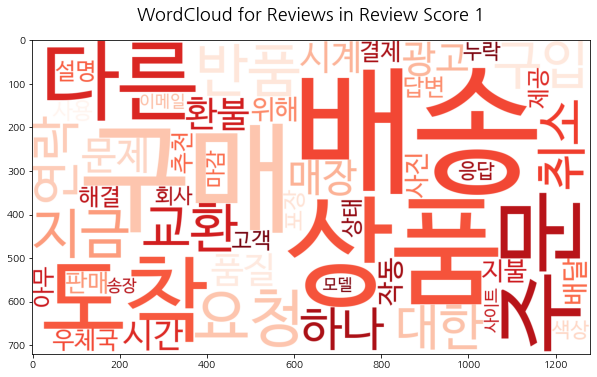

In [103]:
negative_dict = Counter(' '.join(docs).split(' '))
negative_wc = WordCloud(font_path=r"/Library/Fonts/NanumBarunGothic.ttf", 
                        width=1280, height=720, collocations=False, random_state=42, #mask=transf_bomb_mask,
                        colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)
plt.figure(figsize=(10,10))
plt.imshow(negative_wc)
plt.title('WordCloud for Reviews in Review Score 1', size=18, pad=20);